In [1]:
using Turing
using StatsPlots
using Optim

In [2]:
PRINT_PROGRESS = true
include("read_data.jl")
include("utils.jl")
include("lecture/plot_utils.jl");

### Dataset: World-Wide Monthly Air Passengers

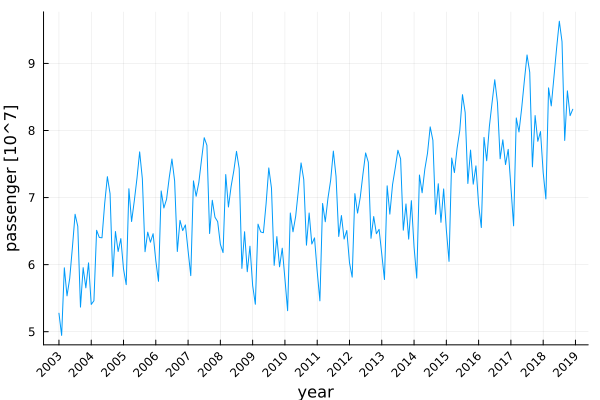

In [5]:
base_plot(air_passengers_2013_2018)

In [19]:
x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"];

In [34]:
@model function trend_model(x::Vector{Float64}, y::Vector{Float64})
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    tau ~ InverseGamma(1,1)

    # UPGRADE: fix one changepoint per year, put restrictive Laplace prior on adjustments
    n_changepoints = length(y) ÷ 12
    adjustments ~ filldist(Laplace(0,tau+1e-5), n_changepoints)
    
    k = slope
    m = intercept
    j = 1
    for i in eachindex(y)
        # UPGRADE: adjust slope and intercept at beginning of each year
        if i % 12 == 1
            k += adjustments[j]
            m -= (x[i] - x[1]) * adjustments[j]
            j += 1
        end
        y[i] ~ Normal(k * (x[i] - x[1]) + m, error+1e-5)
    end
end

trend_model (generic function with 2 methods)

In [35]:
Turing.Random.seed!(0)
res = sample(trend_model(x,y), NUTS(), 3000)
res

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:04


Chains MCMC chain (3000×32×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 66.36 seconds
Compute duration  = 66.36 seconds
parameters        = slope, intercept, error, tau, adjustments[1], adjustments[2], adjustments[3], adjustments[4], adjustments[5], adjustments[6], adjustments[7], adjustments[8], adjustments[9], adjustments[10], adjustments[11], adjustments[12], adjustments[13], adjustments[14], adjustments[15], adjustments[16]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
       parameters      mean       std      mcse    ess_bulk    ess_tail      r ⋯
           Symbol   Float64   Float64   Float64     Float64     Float64   Floa ⋯

            slope    0.4851    0.4330    0.0119   1693.5305   1089.4160    0.9 ⋯
        intercept    5.

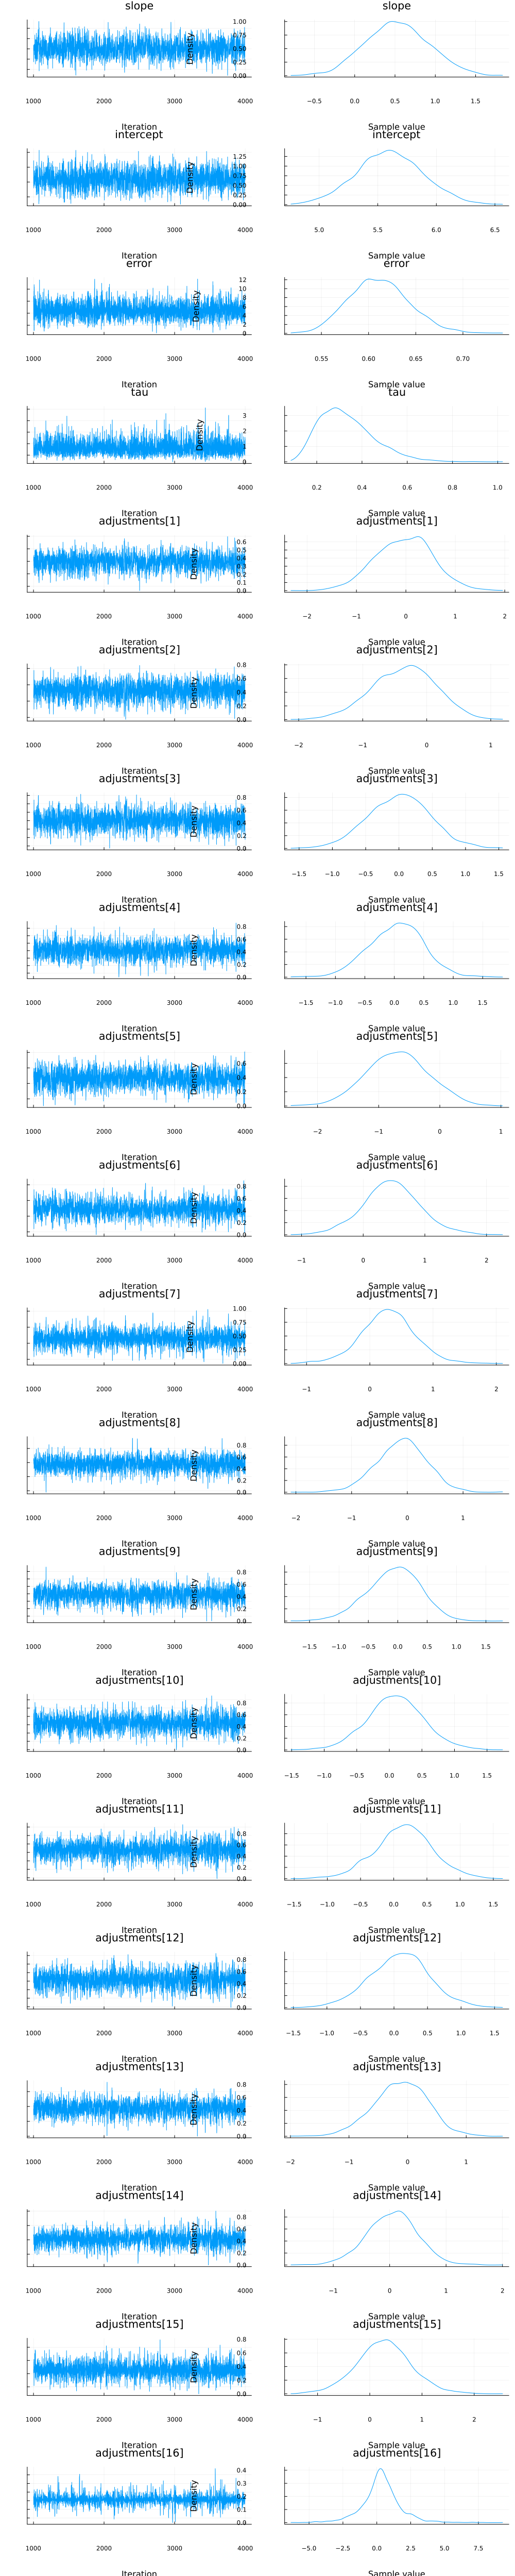

In [32]:
plot(res)

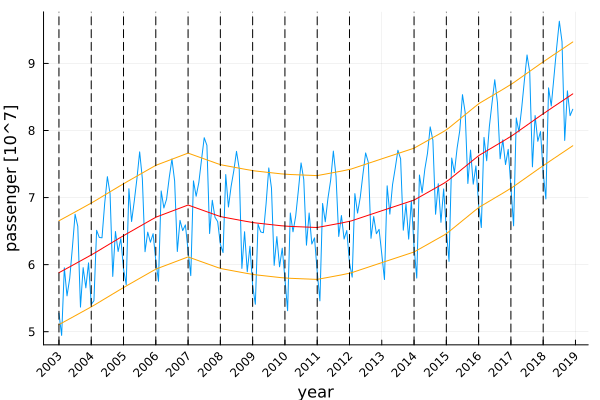

In [36]:
_, map_vector = get_map(res)
plot_trend_model_3(air_passengers_2013_2018, map_vector)

In [37]:
res = optimize(trend_model(x,y), MAP(), Optim.Options(iterations=10_000))

ModeResult with maximized lp of -164.95
[0.2655989336155957, 5.906068720652697, 0.6010083643794552, 0.09199541345535943, 1.8418016686544358e-16, -8.674005781442314e-19, -0.025599904909581975, -0.17889816214404183, -0.09276116993976487, -1.6887703644995532e-16, 1.2691970748013106e-16, 0.030928720902240785, 0.0728998793853017, 0.00040850074223432214, 0.15623752939822977, 0.07632014734989245, 0.0022329676939029197, 2.7895405634532633e-15, 3.987759792310499e-17, -9.32115997167157e-19]

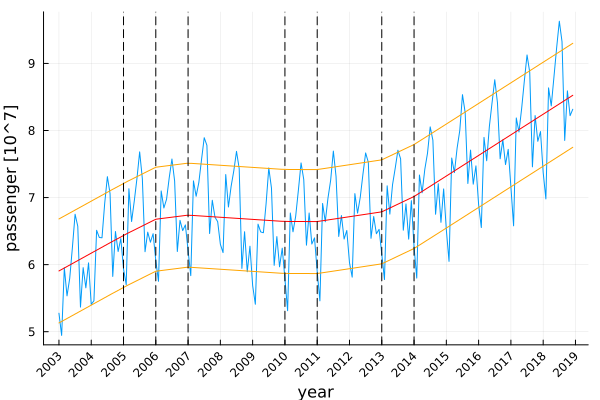

In [39]:
map_vector = res.values.array
plot_trend_model_3(air_passengers_2013_2018, map_vector)